In [1]:
import torch
import pylab as plt

In [2]:
base_path = "./data_nerf/"
models_path = ["vi_nerf_vis","ml_nerf_vis"]
path_ = base_path + models_path[1]

In [3]:
spatial_= torch.load(path_+"/view3/sample0/spatial_size.pt")

In [4]:
spatial_

[1, 256, 256, 128]

In [5]:
rays_worlds = []
rays_density = []
rays_colors =[]
for b in range(16):
    bn = b
    rays_colors.append(torch.load(path_+"/view3/sample0/batch"+str(b)+"/rays_colors.pt"))
    rays_density.append(torch.load(path_+"/view3/sample0/batch"+str(b)+"/rays_densities.pt"))
    rays_worlds.append(torch.load(path_+"/view3/sample0/batch"+str(b)+"/rays_points_world.pt"))
rays_worlds=torch.stack(rays_worlds)
rays_density = torch.stack(rays_density)
rays_colors = torch.stack(rays_colors)

In [6]:
path_vi = base_path + models_path[0]

rays_worlds_vi = []
rays_density_vi = []
rays_colors_vi = []
for sample in range(8):
    rays_density_s = []
    rays_worlds_s = []
    rays_colors_s = []
    for b in range(16):
        bn = b
        rays_colors_s.append(torch.load(path_vi+"/view3/sample"+str(sample)+"/batch"+str(b)+"/rays_colors.pt"))
        rays_density_s.append(torch.load(path_vi+"/view3/sample"+str(sample)+"/batch"+str(b)+"/rays_densities.pt"))
        rays_worlds_s.append(torch.load(path_vi+"/view3/sample"+str(sample)+"/batch"+str(b)+"/rays_points_world.pt"))
    rays_worlds_vi.append(torch.stack(rays_worlds_s))
    rays_density_vi.append(torch.stack(rays_density_s))
    rays_colors_vi.append(torch.stack(rays_colors_s))
rays_worlds_vi=torch.stack(rays_worlds_vi)
rays_density_vi = torch.stack(rays_density_vi)
rays_colors_vi = torch.stack(rays_colors_vi)

In [7]:
rays_worlds_vi=rays_worlds_vi.reshape([8,16*4096*128,3])
rays_density_vi = rays_density_vi.reshape([8,16*4096*128,1])
rays_density_vi_std = rays_density_vi.std(0)
rays_density_vi_mu = rays_density_vi.mean(0)
rays_worlds_vi.shape

torch.Size([8, 8388608, 3])

In [8]:
rays_worlds_flat= rays_worlds.reshape(-1,3)
rays_colors_flat = rays_colors.reshape(-1,3)
rays_colors_vi_flat = rays_colors_vi.reshape([8,16*4096*128,3])
rays_colors_vi_flat_std = rays_colors_vi_flat.std(0).mean(-1)[:,None]
rays_colors_vi_flat_mu = rays_colors_vi_flat.mean(0)

In [9]:
rays_density_flat = rays_density.reshape(-1,1)

In [10]:
rays_density_flat.shape

torch.Size([8388608, 1])

In [11]:
rays_colors_vi_flat_std.shape

torch.Size([8388608, 1])

## Filter out empty voxels to make viz feasible (interesting to play with between 0,0.01,0.75)

In [174]:
ind_nzero = rays_density_flat[:,0] != 0
ind_nzero.sum()

#here you can set the threshold
ind_sel = rays_density_flat[:,0]>0.75#0.8#0.7#0.5#0.205#0.01

rays_density_sel = rays_density_flat[ind_sel]
rays_sel = rays_worlds_flat[ind_sel,:]

density_std_sel = rays_density_vi_std[ind_sel]
density_mu_sel = rays_density_vi_mu[ind_sel]
density_vi_sel = rays_density_vi[:,ind_sel,:]


colors_sel = rays_colors_flat[ind_sel,:] 
colors_vi_sel = rays_colors_vi_flat[:,ind_sel,:]
colors_vi_mu = rays_colors_vi_flat_mu[ind_sel,:]
colors_vi_std = rays_colors_vi_flat_std[ind_sel,:]

ind_sel.sum()

tensor(191784)

In [154]:
rays_sel.shape#max()

torch.Size([191784, 3])

In [155]:
rays_density_flat[:,0].numpy()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [156]:
(rays_density_sel[:,0].numpy()).min()

0.7500024

## Visualizing The MLE Predictions For Latent Densities and Colors of NeRF

Text(0.5, 0.92, 'Predictive Density With ML')

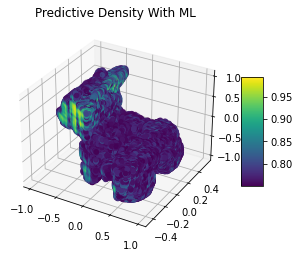

In [157]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=rays_density_sel[:,0])
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Predictive Density With ML")

Text(0.5, 0.92, 'Predictive Colors With ML')

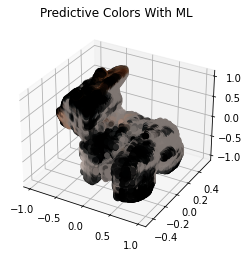

In [158]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_sel)
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Predictive Colors With ML")

## Visualizing the Bayesian Predictions For Latent Densities and Colors of NeRF

Text(0.5, 0.92, 'Predictive Std. over Density')

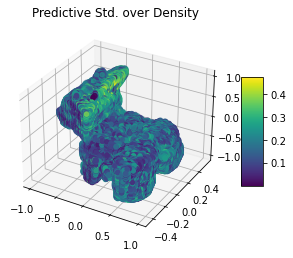

In [159]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=density_std_sel[:,0])
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Predictive Std. over Density")



Text(0.5, 0.92, 'Predictive mean over Density')

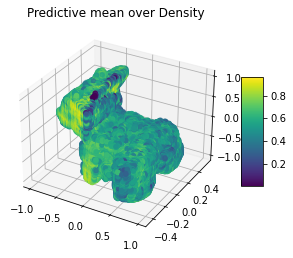

In [160]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=density_mu_sel[:,0])
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Predictive mean over Density")




Text(0.5, 0.92, 'Sample 1 over Density')

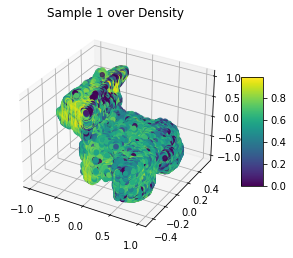

In [161]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=density_vi_sel[0,:])
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 1 over Density")




Text(0.5, 0.92, 'Sample 2 over Density')

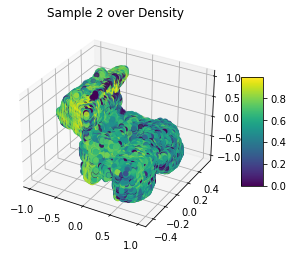

In [162]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=density_vi_sel[1,:])
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 2 over Density")




Text(0.5, 0.92, 'Sample 3 over Density')

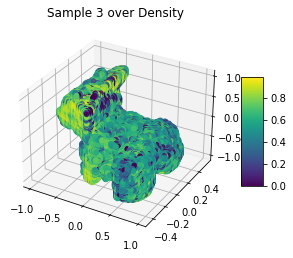

In [163]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=density_vi_sel[2,:])
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 3 over Density")




## Colors

Text(0.5, 0.92, 'Predictive mean over Colors')

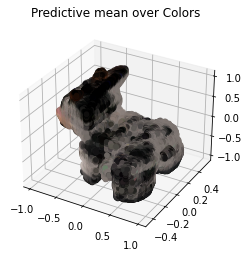

In [164]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_mu)
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Predictive mean over Colors")




Text(0.5, 0.92, 'Predictive Std. over Colors')

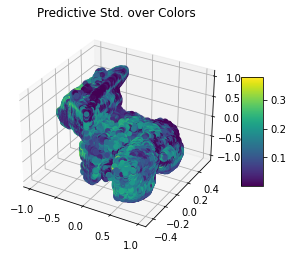

In [165]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_std)
fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Predictive Std. over Colors")

Text(0.5, 0.92, 'Sample 1 over Colors')

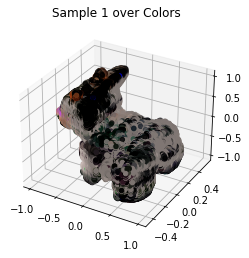

In [166]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[0])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 1 over Colors")



Text(0.5, 0.92, 'Sample 2 over Colors')

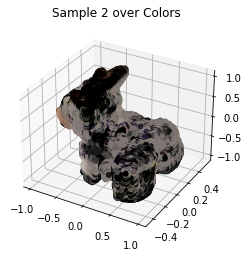

In [167]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[1])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 2 over Colors")

Text(0.5, 0.92, 'Sample 3 over Colors')

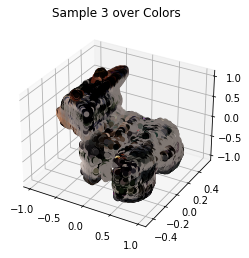

In [168]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[2])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 3 over Colors")

Text(0.5, 0.92, 'Sample 4 over Colors')

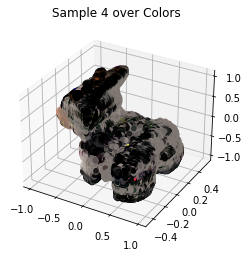

In [169]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[3])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 4 over Colors")

Text(0.5, 0.92, 'Sample 5 over Colors')

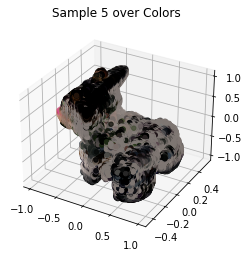

In [170]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[4])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 5 over Colors")

Text(0.5, 0.92, 'Sample 6 over Colors')

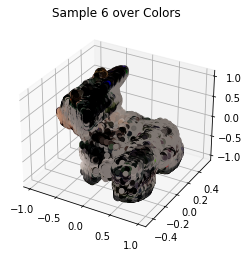

In [171]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[5])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 6 over Colors")


Text(0.5, 0.92, 'Sample 7 over Colors')

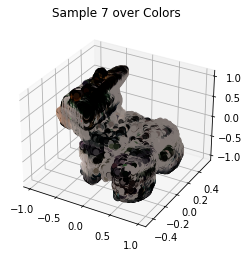

In [172]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[6])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 7 over Colors")

Text(0.5, 0.92, 'Sample 8 over Colors')

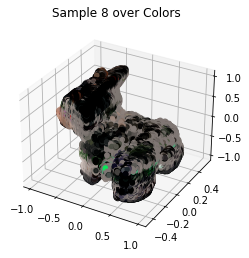

In [173]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(rays_sel[:,2],rays_sel[:,0],rays_sel[:,1], c=colors_vi_sel[7])
# fig.colorbar(sct, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Sample 8 over Colors")